# USAir97 Dataset

## Preliminary steps

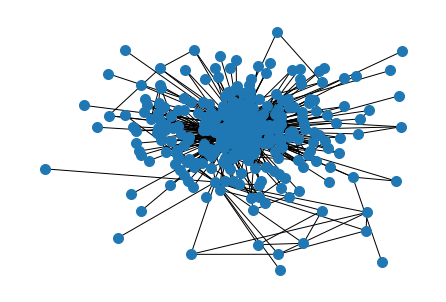

In [ ]:
import networkx as nx
from scipy.io import mmread
import numpy as np
import random as rd
import math

a = mmread('inf-USAir97.mtx')
G = nx.from_scipy_sparse_array(a, edge_attribute='weight')
nx.draw(G, node_size = 100)

In [ ]:
i = 0
node_names = dict()
with open('node_names.txt','r') as file:   
    for line in file:
        node_names[i] = (line[1:-2])
        i += 1
nx.set_node_attributes(G, node_names, "Airport")

## DEGREES AND WEIGHTED DEGREES

In [ ]:
#Degree of $node in $graph
def nodeDegree(graph, node) :
    degree = 0
    for edge in graph.edges(node) :
        degree += 1
    return degree

#Weighted degree of $node in $graph
def weighNodeDegree(graph, node) :
    degree = 0
    for neighbor in graph.neighbors(node) :
        degree += graph.get_edge_data(node, neighbor)["weight"]
    return degree

#Degrees of all nodes in $graph
#$function is the function to be used to compute the degree of a node
def graphDegrees(graph, function) :
    degrees_graph = {}
    for v in graph.nodes :
        degrees_graph[v] = function(graph, v)
    return degrees_graph

## CLOSENESS CENTRALITY

## Exact Algorithms

In [ ]:
#Exact closeness centrality of each node in $graph.
#Returns a dictionary with the name of the nodes as keys and their centrality as values.
def closenessCentralities(graph) :
    sum = []
    closeness_centralities = {}
    n = graph.number_of_nodes()
    for i in range(0, n) :
        sum.append(0)
    for v in range(0, n) :
        for u in range(0, n) :
            sum[v] = sum[v] + nx.dijkstra_path_length(graph, v, u, "weight")
        closeness_centralities[v] = (n - 1) / sum[v]
    return closeness_centralities

#Application of the algorithm on G
closeness_centr_dic = closenessCentralities(G)

In [ ]:
#smarter computation of closeness centralities
def fasterClosenessCentralities(graph) :
    sum = []
    closeness_centralities_faster = {}
    n = graph.number_of_nodes()
    for i in range(0, n) :
        sum.append(0)
    for v in range(0, n) :
        for u in range(v + 1, n) :
            shortest_weighted_path = nx.dijkstra_path_length(graph, v, u, "weight")
            sum[v] += shortest_weighted_path
            sum[u] += shortest_weighted_path
        closeness_centralities_faster[v] = (n - 1) / sum[v]
    return closeness_centralities_faster

#Application of the algorithm on G
faster_closeness_centr_dic = fasterClosenessCentralities(G)

## Eppstein-Wang algorithm

Approximated algorithm to compute the closeness centralities

In [ ]:
#Approximate closeness centrality of each node in $graph.
#Returns a dictionary with the name of the nodes as keys and their centrality as values.
def closenessEppsteinWang(graph, k = 100) :
    sum = []
    closeness_centralities_approx = {}
    n = graph.number_of_nodes()
    for i in range(0, n) :
        sum.append(0)
    for i in range(k) :
        v_i = rd.choice(list(graph.nodes()))
        for v in range(n) :
            sum[v] += nx.dijkstra_path_length(graph, v_i, v, "weight")
    for v in range(n) :
        closeness_centralities_approx[v] = 1 / (n * sum[v] / (k * (n - 1)))
    return closeness_centralities_approx

#Application of the algorithm on G
approx_closeness_centr_dic = closenessEppsteinWang(G)

## BETWEENNESS CENTRALITY

In [ ]:
from random import choice

def approxBetweennessCentr(graph, k = 1000) :
    b = dict.fromkeys(list(graph.nodes()), 0)
    for i in range(k):
        s = choice(list(graph.nodes()))
        t = choice(list(graph.nodes()))
        #print("s: ", s, "t: ", t)
        
        #the try-except block has to be added because we will generate random graphs
        #and they can be not connected
        try :
            shortest_paths = ([p for p in nx.all_shortest_paths(graph, s, t, "weight")])
            shortest_path = choice(shortest_paths)
            #print("list of shortest paths: ")
            #print(shortest_paths)
            #print("shortest path chosen: ")
            #print(shortest_path, "\n")
            for v in shortest_path:
                if v != s and v!= t:
                    b[v] += 1/k
        except nx.NetworkXNoPath :
            #$t is not reachable from $s
            shortest_paths = {}
    return b

#Application of the algorithm on G
approx_betweenness_centr_dic = approxBetweennessCentr(G)

## CLUSTERING COEFFICIENT

## Exact Local Clustering Coefficient for weighted graphs

To compute the local clustering coefficient of a node in a weighted graph, we can use the following steps:

1) Find the neighbors of the node. A node's neighbors are all the nodes that are directly connected to it by an edge.

2) Calculate the sum of the weights of the edges between the node's neighbors. This is the total weight of the edges that connect the node's neighbors to each other.

3) Calculate the maximum possible sum of the weights of the edges between the node's neighbors. This is the total weight of the edges that would be present if all of the node's neighbors were fully connected to each other.

4) Calculate the local clustering coefficient by dividing the actual sum of the weights of the edges between the node's neighbors by the maximum possible sum of the weights of the edges between the node's neighbors.

In [ ]:
def weighted_lcc(graph, node):
    neighbors = graph.neighbors(node)
    actual_sum = 0
    max_possible_sum = 0
    for i, neighbor_1 in enumerate(neighbors):
        for j, neighbor_2 in enumerate(neighbors):
            if i < j:
                if [neighbor_1, neighbor_2] in graph.edges:
                    actual_sum += graph.edges[neighbor_1, neighbor_2]["weight"]
                max_possible_sum += 1
    if max_possible_sum < 1:
        return 0
    return actual_sum / max_possible_sum

In [ ]:
# compute all weighted lccs of nodes in graph G
def weigthed_lccs(graph):
    cc = dict()
    for v in graph.nodes():
        cc[v] = weighted_lcc(graph, v)
    return cc

## Approximated Local Clustering Coefficient for weigthed graphs

One way to approximate the local clustering coefficient of a node in a large graph is to use a technique called "random sampling". This involves randomly selecting a subset of the graph and using that subset to estimate the local clustering coefficient of the node. Note that the accuracy of this approximation will depend on the size of the sample and the structure of the graph. A larger sample size will typically lead to a more accurate approximation, but at the cost of increased computational complexity.

In [ ]:
def estimate_weighted_lcc(graph, node, sample_size=2):
    num_neighbors = 0
    for neighbor in graph.neighbors(node):
        num_neighbors += 1

    if num_neighbors <= 1:
        return 0

    # Sample a random subset of the graph
    sample = rd.sample(list(graph.nodes()), sample_size)

    # Calculate the actual sum of the weights of the edges between the node's neighbors
    actual_sum = 0
    for i, neighbor_1 in enumerate(graph.neighbors(node)):
        for j, neighbor_2 in enumerate(graph.neighbors(node)):
            if i < j:
                if [neighbor_1, neighbor_2] in graph.edges:
                    actual_sum += graph.get_edge_data(neighbor_1, neighbor_2, default=0)['weight']

    # Calculate the maximum possible sum of the weights of the edges between the node's neighbors
    max_possible_sum = num_neighbors * (num_neighbors - 1) / 2

    # Calculate the local clustering coefficient
    if max_possible_sum != 0:
        local_cc = actual_sum / max_possible_sum
    else: 
        local_cc = 0
        
    # Calculate the number of neighbors in the sample
    num_neighbors_in_sample = len([n for n in graph.neighbors(node) if n in sample])

    # Calculate the number of edges between neighbors in the sample
    num_edges_between_neighbors_in_sample = 0
    for i, neighbor_1 in enumerate(graph.neighbors(node)):
        if neighbor_1 in sample:
            for j, neighbor_2 in enumerate(graph.neighbors(node)):
                if i < j and neighbor_2 in sample:
                    num_edges_between_neighbors_in_sample += 1

    # Calculate the approximated local clustering coefficient
    if num_neighbors_in_sample >= 2: 
        approx_local_cc = (local_cc * num_edges_between_neighbors_in_sample) / (num_neighbors_in_sample * (num_neighbors_in_sample - 1) / 2)
    else:
        return 0
    
    return approx_local_cc

In [ ]:
# compute an estimate of all lccs of nodes in graph G
def estimate_weigthed_lccs(graph, sample_size=10):
    cc = dict()
    for v in graph.nodes():
        cc[v] = estimate_weighted_lcc(graph, v, sample_size=sample_size)
    return cc

## Clustering Coefficient Of A Graph

In [ ]:
def BetterCC(graph):
    numt = 0
    for u in graph.nodes:
        for v in list(graph.neighbors(u)):
            for z in list(graph.neighbors(u)):
                if (v != z and graph.has_edge(v, z)):
                    numt += 1
    return (numt / (6 * math.comb(graph.number_of_nodes(), 3)))

## Approximate Clustering Coefficient Of A Graph

In [ ]:
def pathLengthTwo(graph, u_z_equals = True):
    u = (rd.sample(graph.nodes, 1))[0]
    neigh = [n for n in graph.neighbors(u)]
    v = (rd.sample(neigh, 1))[0]
    neigh = [n for n in graph.neighbors(v)]
    z = (rd.sample(neigh, 1))[0]
    if not u_z_equals:
        while (u == z):
            z = (rd.sample(neigh, 1))[0]
    return u, v, z

def ApproximateCC(graph, k):
    P = 0
    d = dict()
    for u in graph.nodes:
        d[u] = sum(1 for _ in graph.neighbors(u))
        P += (d[u] / 2) * (d[u] - 1)
    
    beta = dict()
    for i in range(k):
        u, v, z = pathLengthTwo(graph)
        if graph.has_edge(u, z):
            beta[i] = 1
        else:
            beta[i] = 0
    numt = (1 / k) * (sum(beta[i] for i in range(k))) * P/3
    return numt / math.comb(graph.number_of_nodes(), 3)

print (ApproximateCC(G, 1000))

0.0011642991079947364


## Random graphs generation
1. Erdos-Renyi-Gilbert unweighted random graphs are generated (same number of nodes of the original graph $G and each edge appearing with probability $p). $p is chosen such that E[m(n, p)] (i. e. the expected value of the number of edges of the randomly generated graph) is equal to the number of edges $m of the real network.
2. Weights are added choosing them uniformly at random in the interval [$min_weight, $max_weight), where:
    - $min_weight is the minimal weight in the original graph $G;
    - $max_weight is the maximal weight in the original graph $G;
Each edge is associated with a weight that represents the frequency of the flights between the two cities (nodes).

In [ ]:
#find maximal weight
def maxWeight(graph) :
    max_weight = 0
    for v in graph.nodes :
        for u in graph.neighbors(v) :
           if (graph[v][u]["weight"] > max_weight) :
                max_weight = graph[v][u]["weight"]
    return max_weight

#find minimal weight
def minWeight(graph) :
    min_weight = 100
    for v in graph.nodes :
        for u in graph.neighbors(v) :
            if (graph[v][u]["weight"] < min_weight) :
                min_weight = graph[v][u]["weight"]
    return min_weight

#Generate a Erdos-Renyi-Gilbert random graph with uniformly chosen weights based on $graph
def oneRandomGraphGen(graph, p = 0.5) :
    #Erdos-Renyi random graphs: they are not weighted
    random_G = nx.gnp_random_graph(graph.number_of_nodes(), p)
    #Add uniformly chosen weights to the random graph. Wheights are chosen from $min_weight and $max_weight
    min_weight_G = minWeight(graph)
    max_weight_G = maxWeight(graph)
    random_weighted_edges = {}
    for edge in random_G.edges :
        random_weighted_edges[edge] = np.random.uniform(min_weight_G, max_weight_G)
    nx.set_edge_attributes(random_G, random_weighted_edges, "weight")    
    return random_G

#Generate $num_graphs Erdos-Renyi random graphs with uniformly chosen weights based on $graph
def randomGraphsGen(graph, num_graphs = 100, p = 0.5) :
    random_graphs = []
    for i in range(num_graphs) :
        random_graphs.append(oneRandomGraphGen(graph, p))
    return random_graphs

#generate 10 random graphs with expected number of edges equal to the number of edges of G
prob = G.number_of_edges() / np.math.comb(G.number_of_nodes(), 2)
list_random_graphs = randomGraphsGen(G, num_graphs = 10, p = prob)

## Random graphs with weights chosen in a normal distribution
Given a random Erdos-Renyi-Gilbert graph G(n, m), instead of choosing weights uniformly at random in [$minWeight(G), maxWeight(G)), we build a Normal distribution around the mean weight of \$G and use it to assign the weights to the random graphs.

In [ ]:
#compute the mean weight of $graph
def meanWeight(graph) :
    mean = 0
    for i, edge in enumerate(graph.edges()) :
        #we do not simply consider the sum to avoid overflow ($graph can be very large)
        mean = (mean * i + graph.get_edge_data(*edge)["weight"]) / (i + 1)
    return mean

#return a list containing the weights in $graph
def listWeights(graph) :
    weights = []
    for edge in graph.edges() :
        weights.append(graph.get_edge_data(*edge)["weight"])
    return weights

#return a weight sampled according to a normal distribution around the mean weight of $graph
#and with standard deviation equal to the standard deviation of weights in $graph.add_edge.
#only positive weights are accepted
def normalSampledWeight(graph, mean_weight_graph, std_graph) :
    sampled_weight = np.random.normal(mean_weight_graph, std_graph, 1)
    while sampled_weight < 0 :
        sampled_weight = np.random.normal(mean_weight_graph, std_graph, 1)
    
    #necessary otherwise an array of one element is returned
    return sampled_weight[0]

#Generate a Erdos-Renyi-Gilbert random graph with weights chosen in a normal distribution based on $graph
def oneRandomGraphNormalWeights(graph, mean_weight_graph, std_weights_graph, p = 0.5) :
    #Erdos-Renyi random graphs: they are not weighted
    random_G = nx.gnp_random_graph(graph.number_of_nodes(), p)

    #sample weights using a normal distribution obtained from $graph
    random_weighted_edges = {}
    for edge in random_G.edges :
        random_weighted_edges[edge] = normalSampledWeight(graph, mean_weight_graph, std_weights_graph)
    nx.set_edge_attributes(random_G, random_weighted_edges, "weight")    
    
    return random_G

#Generate $num_graphs Erdos-Renyi-Gilbert random graph with weights chosen in a normal distribution based on $graph
def randomGraphsNormalWeights(graph, num_graphs = 100, p = 0.5) :
    #compute the standard deviation of the weights of $graph
    weights_graph = listWeights(graph)
    std = np.std(weights_graph, ddof = 0)
    
    #compute the mean weight of $graph
    mean = meanWeight(graph)

    random_graphs = []
    for i in range(num_graphs) :
        random_graphs.append(oneRandomGraphNormalWeights(graph, mean, std, p))
    
    return random_graphs

#generate 10 random graphs with expected number of edges equal to the number of edges of G
list_random_graphs_normal = randomGraphsNormalWeights(G, num_graphs = 10, p = prob)

## Random graphs with same number of nodes and sequence of degrees as G
When an edge swap is made, in order to preserve the sequence of degrees of nodes in G also in the random graph, the new edge will have the same weight of the removed one. Example:
(u, v)[w1] and (w, z)[w2] are removed while (u, z)[w1] and (v, w)[w2] are added.

Remember also that k must be a multiple of the number of edges of G.

In [ ]:
import copy

#function to generate a random graph with same number of nodes and degree sequence as $graph
#$k is the factor by which the number of edges of $graph is multiplied to obtain the number of iterations
def oneRandomGraphSameDeg(graph, k = 1) :
    random_g = copy.deepcopy(graph)
    num_iterations = k * graph.number_of_edges()
    for i in range(num_iterations) :
        #sample two edges uniformly at random in $random_g
        edge_1 = rd.choice(list(random_g.edges()))
        edge_2 = rd.choice(list(random_g.edges()))
        
        #create the two edges that will replace $edge_1 and $edge_2 in $random_g
        new_edge_1 = (edge_1[0], edge_2[1])
        new_edge_2 = (edge_1[1], edge_2[0])

        #check that the $new_edge_1 and $new_edge_2 do not already exist in $random_g
        if (not random_g.has_edge(*new_edge_1)) and (not random_g.has_edge(*new_edge_2)) :
            #save the weights of $edge_1 and $edge_2 before removing them
            weight_1 = random_g.get_edge_data(*edge_1)["weight"]
            weight_2 = random_g.get_edge_data(*edge_2)["weight"]

            #remove $edge_1 and $edge_2 from $random_g
            random_g.remove_edge(*edge_1)
            random_g.remove_edge(*edge_2)

            #add $new_edge_1 and $new_edge_2 to $random_g
            random_g.add_edge(*new_edge_1)
            nx.set_edge_attributes(random_g, {(new_edge_1[0], new_edge_1[1]): weight_1}, "weight")
            random_g.add_edge(*new_edge_2)
            nx.set_edge_attributes(random_g, {(new_edge_2[0], new_edge_2[1]): weight_2}, "weight")

    return random_g

#generate a list of random graphs with same number of nodes and degree sequence as $graph
#$k is the factor by which the number of edges of $graph is multiplied to obtain the number of swaps attempted
def randGraphsDeg(graph, number_graphs = 100, k = 1) :
    list_graphs = []
    for i in range(number_graphs) :
        list_graphs.append(oneRandomGraphSameDeg(graph, k))
    return list_graphs

#generate 10 random graphs with expected number of edges equal to the number of edges of G
list_random_graphs_degree = randGraphsDeg(G, number_graphs = 10, k = 1)

## Random graphs properties computation
1. Computation of some properties on the random graphs generated above.
2. Print of the computed properties for some random graphs chosen uniformly at random.

Note: 
- "u_" is used to indicate graphs with weights generated uniformly at random;
- "n_" is used to indicate graphs with weights taken from a normal distibution;
- "d_" is used to indicate graphs with same degree sequence;

In [ ]:
#Prints $n elements of $list chosen uniformly at random.
#$list_name is a string identifying the $list.
#$element_name is a string identifying the type of elements contained in $list.
#Returns a list containing the indices of the randomly chosen elements in $list.
def print_n_random_in_list(list, n = 3, list_name = "list", element_name = "element") :
    print("\n" + list_name)
    indices_list = []
    for i in range(n) :
        indices_list.append(rd.choice(range(len(list))))
        print("\n" + element_name + " " + str(indices_list[i]) + ":")
        print(list[indices_list[i]])
    return indices_list

### Uniform weights: features computation

In [ ]:
#Weighted degrees
u_list_of_dic_degrees = []
for graph in list_random_graphs :
    u_list_of_dic_degrees.append(graphDegrees(graph, weighNodeDegree))

#Closeness centrality: exact algorithm
u_list_of_dic_closeness = []
for graph in list_random_graphs :
    u_list_of_dic_closeness.append(nx.closeness_centrality(graph, distance = "weight"))

#Betweenness centrality: exact algorithm
u_list_of_dic_betweenness = []
for graph in list_random_graphs :
    u_list_of_dic_betweenness.append(nx.betweenness_centrality(graph, weight = "weight"))

#Betweenness centrality: approximate algorithm
u_list_of_dic_approx_betweenness = []
for graph in list_random_graphs :
    u_list_of_dic_approx_betweenness.append(approxBetweennessCentr(graph))

#Local clustering coefficient: exact algorithm
u_list_of_list_lccs = []
for graph in list_random_graphs :
    u_list_of_list_lccs.append(weigthed_lccs(graph))

#Local clustering coefficient: approximate algorithm
u_list_of_list_approx_lccs = []
for graph in list_random_graphs :
    u_list_of_list_approx_lccs.append(estimate_weigthed_lccs(graph))

### Uniform weights: print of results

In [ ]:
#Degrees of $n graphs chosen uniformly at random
#u_indices_degrees = print_n_random_in_list(u_list_of_dic_degrees, list_name = "degrees", element_name = "graph")

#Exact closeness centralities of $n graphs chosen uniformly at random
#u_indices_clos_centr = print_n_random_in_list(u_list_of_dic_closeness, list_name = "closeness",
#                                              element_name = "graph")

#Exact betweenness centralities of $n graphs chosen uniformly at random
#u_indices_betw_centr = print_n_random_in_list(u_list_of_dic_betweenness, list_name = "betweenness",
#                                              element_name = "graph")

#Approximate betweenness centralities of $n graphs chosen uniformly at random
#u_indices_approx_betw_centr = print_n_random_in_list(u_list_of_dic_approx_betweenness,
#                                                     list_name = "approx betweenness", element_name = "graph")

#Exact local clustering coeeficients of $n graphs chosen uniformly at random
#u_indices_lccs = print_n_random_in_list(u_list_of_list_lccs, list_name = "lccs", element_name = "graph")

#Approximate local clustering coeeficients of $n graphs chosen uniformly at random
#u_indices_approx_lccs = print_n_random_in_list(u_list_of_list_approx_lccs, list_name = "approx lccs",
#                                               element_name = "graph")

### Normal weights: features computation

In [ ]:
#Weighted degrees
n_list_of_dic_degrees = []
for graph in list_random_graphs_normal :
    n_list_of_dic_degrees.append(graphDegrees(graph, weighNodeDegree))

#Closeness centrality: exact algorithm
n_list_of_dic_closeness = []
for graph in list_random_graphs_normal :
    n_list_of_dic_closeness.append(nx.closeness_centrality(graph, distance = "weight"))

#Betweenness centrality: exact algorithm
n_list_of_dic_betweenness = []
for graph in list_random_graphs_normal :
    n_list_of_dic_betweenness.append(nx.betweenness_centrality(graph, weight = "weight"))

#Betweenness centrality: approximate algorithm
n_list_of_dic_approx_betweenness = []
for graph in list_random_graphs_normal :
    n_list_of_dic_approx_betweenness.append(approxBetweennessCentr(graph))

#Local clustering coefficient: exact algorithm
n_list_of_list_lccs = []
for graph in list_random_graphs_normal :
    n_list_of_list_lccs.append(weigthed_lccs(graph))

#Local clustering coefficient: approximate algorithm
n_list_of_list_approx_lccs = []
for graph in list_random_graphs_normal :
    n_list_of_list_approx_lccs.append(estimate_weigthed_lccs(graph))

### Normal weights: print of results

In [ ]:
#Degrees of $n graphs chosen uniformly at random
#n_indices_degrees = print_n_random_in_list(n_list_of_dic_degrees,  list_name = "degrees", element_name = "graph")

#Exact closeness centralities of $n graphs chosen uniformly at random
#n_indices_clos_centr = print_n_random_in_list(n_list_of_dic_closeness,  list_name = "closeness",
#                                              element_name = "graph")

#Exact betweenness centralities of $n graphs chosen uniformly at random
#n_indices_betw_centr = print_n_random_in_list(n_list_of_dic_betweenness, list_name = "betweenness",
#                                              element_name = "graph")

#Approximate betweenness centralities of $n graphs chosen uniformly at random
#n_indices_approx_betw_centr = print_n_random_in_list(n_list_of_dic_approx_betweenness,
#                                                     list_name = "approx betweenness", element_name = "graph")

#Exact local clustering coeeficients of $n graphs chosen uniformly at random
#n_indices_lccs = print_n_random_in_list(n_list_of_list_lccs, list_name = "lccs", element_name = "graph")

#Approximate local clustering coeeficients of $n graphs chosen uniformly at random
#n_indices_approx_lccs = print_n_random_in_list(n_list_of_list_approx_lccs, list_name = "approx lccs",
#                                               element_name = "graph")

### Same degree sequence: features computation

In [ ]:
#Weighted degrees
d_list_of_dic_degrees = []
for graph in list_random_graphs_degree :
    d_list_of_dic_degrees.append(graphDegrees(graph, weighNodeDegree))

#Closeness centrality: exact algorithm
d_list_of_dic_closeness = []
for graph in list_random_graphs_degree :
    d_list_of_dic_closeness.append(nx.closeness_centrality(graph, distance = "weight"))

#Betweenness centrality: exact algorithm
d_list_of_dic_betweenness = []
for graph in list_random_graphs_degree :
    d_list_of_dic_betweenness.append(nx.betweenness_centrality(graph, weight = "weight"))

#Betweenness centrality: approximate algorithm
d_list_of_dic_approx_betweenness = []
for graph in list_random_graphs_degree :
    d_list_of_dic_approx_betweenness.append(approxBetweennessCentr(graph))

#Local clustering coefficient: exact algorithm
d_list_of_list_lccs = []
for graph in list_random_graphs_degree :
    d_list_of_list_lccs.append(weigthed_lccs(graph))

#Local clustering coefficient: approximate algorithm
d_list_of_list_approx_lccs = []
for graph in list_random_graphs_degree :
    d_list_of_list_approx_lccs.append(estimate_weigthed_lccs(graph))

### Same degree sequence: print of results

In [ ]:
#Degrees of $n graphs chosen uniformly at random
#d_indices_degrees = print_n_random_in_list(d_list_of_dic_degrees,  list_name = "degrees", element_name = "graph")

#Exact closeness centralities of $n graphs chosen uniformly at random
#d_indices_clos_centr = print_n_random_in_list(d_list_of_dic_closeness,  list_name = "closeness",
#                                              element_name = "graph")

#Exact betweenness centralities of $n graphs chosen uniformly at random
#d_indices_betw_centr = print_n_random_in_list(d_list_of_dic_betweenness, list_name = "betweenness",
#                                              element_name = "graph")

#Approximate betweenness centralities of $n graphs chosen uniformly at random
#d_indices_approx_betw_centr = print_n_random_in_list(d_list_of_dic_approx_betweenness,
#                                                     list_name = "approx betweenness", element_name = "graph")

#Exact local clustering coeeficients of $n graphs chosen uniformly at random
#d_indices_lccs = print_n_random_in_list(d_list_of_list_lccs, list_name = "lccs", element_name = "graph")

#Approximate local clustering coeeficients of $n graphs chosen uniformly at random
#d_indices_approx_lccs = print_n_random_in_list(d_list_of_list_approx_lccs, list_name = "approx lccs",
#                                               element_name = "graph")

## Monte Carlo approach
1. The random graphs have already been generated;
2. Features of interest have already been computed for all the graphs;
3. Now, we want to understand if some features of G are significant or not. To do so, we try to estimate the p-value.

Both for closeness centrality and betweenness centrality, we proceed as follows:
- find the node of $G with highest centrality;
- find the node with highest centrality in each random graph (the three different types of random graphs are used);
- estimate the p-value; 

### Utility functions

In [ ]:
#return the key of the largest value in the dictionary $dic
def keyMaxVal(dic) :
    key_max = list(dic.keys())[0]
    for key in dic :
        if dic[key] > dic[key_max] :
            key_max = key
    return key_max

#return the mean value in a dictionary $dic
def meanValDic(dic) :
    sum = 0
    for val in dic.values() :
        sum += val
    return sum / len(dic)

#return a list of values $mean_values
#$list_dic is a list of dictionaries
#$mean_values[i] is the mean value in the dictionary $list_dic[i]
def listMeanValsDic(list_dic) :
    mean_values = []
    for dic in list_dic :
        mean_values.append(meanValDic(dic))
    return mean_values

#return a list of indices $list_keys_largest
#$list_dic is a list of dictionaries
#$list_key_largest[i] is the key in the dictionary $list_dic[i] of the largest value in $list_dic[i]
def listKeysMax(list_dic) :
    list_keys_largest = []
    for dic in list_dic :
        list_keys_largest.append(keyMaxVal(dic))
    return list_keys_largest

#print $list_of_dict[i][list_of_keys[key]] for every key in $list_of_keys
def printGivenKeys(list_of_dict, list_of_keys) :
    for i,key in enumerate(list_of_keys) :
        print(list_of_dict[i][key])


#estimation of p-value: probab[$list_of_feature[i] >= $true_feature]
def estimatePVal(true_feature, list_of_features) :
    count = 0
    for feat in list_of_features :
        if feat > true_feature :
            count += 1
    return count / len(list_of_features)

#from a list of keys return the corresponding values in a list
def listValFromListKeys(list_of_dics, list_of_keys) :
    list_of_val = []
    for i,key in enumerate(list_of_keys) :
        list_of_val.append(list_of_dics[i][key])
    return list_of_val




### p-value highest closeness centrality

In [ ]:
#find the node with largest closeness centrality in $G
key_largest_cl = keyMaxVal(closeness_centr_dic)
print("\nReal network:")
print(closeness_centr_dic[key_largest_cl])

#find the nodes with largest closeness centrality in the random graphs with same degree sequence as $G
d_list_keys_largest_cl = listKeysMax(d_list_of_dic_closeness)
print("\nRandom graphs same degree sequence:")
printGivenKeys(d_list_of_dic_closeness, d_list_keys_largest_cl)

#find the nodes with largest closeness centrality in the random graphs with uniformly distributed weights
u_list_keys_largest_cl = listKeysMax(u_list_of_dic_closeness)
print("\nRandom graphs uniform:")
printGivenKeys(u_list_of_dic_closeness, u_list_keys_largest_cl)

#find the nodes with largest closeness centrality in the random graphs with uniformly distributed weights
n_list_keys_largest_cl = listKeysMax(n_list_of_dic_closeness)
print("\nRandom graphs normal:")
printGivenKeys(n_list_of_dic_closeness, n_list_keys_largest_cl)


Real network:
6.584273730737017

Random graphs same degree sequence:
28.24810541407796
24.906881372512128
25.98238535566826
25.80997309836642
26.33798558174324
25.898830249207784
28.465037881719585
26.429044801622457
26.41681098811644
24.819477666219253

Random graphs uniform:
4.9199529604515835
5.643640969745863
5.069355996329437
5.813281586468583
5.072106603022638
5.210442334048537
4.9740877875506815
5.06379540529841
4.847137738935255
6.109120482006496

Random graphs normal:
12.438412087856259
14.038286027115932
13.681944366265276
12.757390387988256
14.267651249562283
14.181451981301544
15.634028534197197
15.313155518496547
12.823211360521757
13.981946049781058


In [ ]:
#p-value for random graphs with same degree sequence
d_p_val = estimatePVal(closeness_centr_dic[key_largest_cl], listValFromListKeys(d_list_of_dic_closeness,
                                                                                d_list_keys_largest_cl))
print("\np_value same deg: " + str(d_p_val))

#p-value for random graphs with uniformly distributed weights
u_p_val = estimatePVal(closeness_centr_dic[key_largest_cl], listValFromListKeys(u_list_of_dic_closeness,
                                                                                u_list_keys_largest_cl))
print("\np_value uniform: " + str(u_p_val))

#p-value for random graphs with uniformly distributed weights
n_p_val = estimatePVal(closeness_centr_dic[key_largest_cl], listValFromListKeys(n_list_of_dic_closeness,
                                                                                n_list_keys_largest_cl))
print("\np_value normal: " + str(n_p_val))


p_value same deg: 1.0

p_value uniform: 0.0

p_value normal: 1.0


### p-value mean closeness centrality

In [ ]:
#find the mean closeness centrality of nodes in $G
mean_clos_G = meanValDic(closeness_centr_dic)
print("\nReal network:")
print(mean_clos_G)

#find the mean closeness centrality of nodes in the random graphs with same degree sequence as $G
d_mean_clos = listMeanValsDic(d_list_of_dic_closeness)
print("\nRandom graphs same degree sequence:")
print(d_mean_clos)

#find the mean closeness centrality of nodes in the random graphs with uniformly distributed weights
u_mean_clos = listMeanValsDic(u_list_of_dic_closeness)
print("\nRandom graphs uniform:")
print(u_mean_clos)

#find the mean closeness centrality of nodes in the random graphs with uniformly distributed weights
n_mean_clos = listMeanValsDic(n_list_of_dic_closeness)
print("\nRandom graphs normal:")
print(n_mean_clos)


Real network:
4.943537722155358

Random graphs same degree sequence:
[18.650546643690724, 17.057725067976428, 17.401046177587403, 17.560613892335745, 18.18263165371207, 16.999174180078477, 17.984770065709508, 17.96425126473743, 17.72595182530996, 17.04154884456881]

Random graphs uniform:
[3.694992719803047, 3.955725286392223, 3.5755496768934054, 4.2198281578717145, 3.855361670455142, 3.8030420287962667, 3.519749708431215, 3.6487266652019863, 3.6922743643965004, 4.293829519932718]

Random graphs normal:
[9.33766738815415, 10.053704904582865, 9.999286719616167, 9.83357030032529, 10.208464691009508, 9.826525174032204, 10.880729664496318, 10.862904098856303, 9.285586660868997, 10.23704060272002]


In [ ]:
#p-value for random graphs with same degree sequence
d_p_val_mean = estimatePVal(mean_clos_G, d_mean_clos)
print("\np_value same deg: " + str(d_p_val_mean))

#p-value for random graphs with uniformly distributed weights
u_p_val_mean = estimatePVal(mean_clos_G, u_mean_clos)
print("\np_value uniform: " + str(u_p_val_mean))

#p-value for random graphs with uniformly distributed weights
n_p_val_mean = estimatePVal(mean_clos_G, n_mean_clos)
print("\np_value normal: " + str(n_p_val_mean))


p_value same deg: 1.0

p_value uniform: 0.0

p_value normal: 1.0


### p-value highest betweenness centrality

In [ ]:
#find the node with largest betweennes centrality in $G
b_true = nx.betweenness_centrality(G, weight = "weight")
key_largest_bet = keyMaxVal(b_true)
print("\nReal network:")
print(b_true[key_largest_bet])

#find the nodes with largest betweenness centrality in the random graphs with same degree sequence as $G
d_list_keys_largest_bet = listKeysMax(d_list_of_dic_betweenness)
print("\nRandom graphs same degree sequence:")
printGivenKeys(d_list_of_dic_betweenness, d_list_keys_largest_bet)

#find the nodes with largest betweenness centrality in the random graphs with uniformly distributed weights
u_list_keys_largest_bet = listKeysMax(u_list_of_dic_betweenness)
print("\nRandom graphs uniform:")
printGivenKeys(u_list_of_dic_betweenness, u_list_keys_largest_bet)

#find the nodes with largest betweenness centrality in the random graphs with uniformly distributed weights
n_list_keys_largest_bet = listKeysMax(n_list_of_dic_betweenness)
print("\nRandom graphs normal:")
printGivenKeys(n_list_of_dic_betweenness, n_list_keys_largest_bet)


Real network:
0.1532957978577314

Random graphs same degree sequence:
0.22527693856998993
0.14009429643870733
0.16765082852696145
0.17575757575757575
0.15785651072660137
0.22434312917696603
0.30799230980499864
0.1538542524947359
0.20025786566572062
0.14478623088894993

Random graphs uniform:
0.10253593335164332
0.1538588299917605
0.11352192621074797
0.09781195642222833
0.08642314382495651
0.10751625011443743
0.1374713906435961
0.11328389636546736
0.07891604870456834
0.13446855259544083

Random graphs normal:
0.08030760780005493
0.11661631419939578
0.11421770575849126
0.07686533003753547
0.1119472672342763
0.13710519088162593
0.14371509658518722
0.12703469742744666
0.12177973084317495
0.10072324452989105


In [ ]:
#p-value for random graphs with same degree sequence
d_p_val_bet = estimatePVal(b_true[key_largest_bet], listValFromListKeys(d_list_of_dic_betweenness,
                                                                                d_list_keys_largest_bet))
print("\np_value same deg: " + str(d_p_val_bet))

#p-value for random graphs with uniformly distributed weights
u_p_val_bet = estimatePVal(b_true[key_largest_bet], listValFromListKeys(u_list_of_dic_betweenness,
                                                                                u_list_keys_largest_bet))
print("\np_value uniform: " + str(u_p_val_bet))

#p-value for random graphs with uniformly distributed weights
n_p_val_bet = estimatePVal(b_true[key_largest_bet], listValFromListKeys(n_list_of_dic_betweenness,
                                                                                n_list_keys_largest_bet))
print("\np_value normal: " + str(n_p_val_bet))


p_value same deg: 0.8

p_value uniform: 0.1

p_value normal: 0.0


### p-value mean betweenness centrality

In [ ]:
#find the mean betweenness centrality of nodes in $G
mean_bet_G = meanValDic(b_true)
print("\nReal network:")
print(mean_bet_G)

#find the mean betweenness centrality of nodes in the random graphs with same degree sequence as $G
d_mean_bet = listMeanValsDic(d_list_of_dic_betweenness)
print("\nRandom graphs same degree sequence:")
print(d_mean_bet)

#find the mean betweenness centrality of nodes in the random graphs with uniformly distributed weights
u_mean_bet = listMeanValsDic(u_list_of_dic_betweenness)
print("\nRandom graphs uniform:")
print(u_mean_bet)

#find the mean betweenness centrality of nodes in the random graphs with uniformly distributed weights
n_mean_bet = listMeanValsDic(n_list_of_dic_betweenness)
print("\nRandom graphs normal:")
print(n_mean_bet)


Real network:
0.0066411512122817925

Random graphs same degree sequence:
[0.010898905518623062, 0.01048082286115992, 0.010566820977951906, 0.011169451218772367, 0.010456133790862432, 0.01058584332753517, 0.010249622494371887, 0.010317733444075673, 0.010622697693640075, 0.010108110736454934]

Random graphs uniform:
[0.012331997586611198, 0.013916363062797737, 0.013392598132160627, 0.013480508135260073, 0.01272919196698907, 0.013021710572032708, 0.012354388716635297, 0.013373571186696806, 0.012765370738653598, 0.013246890335304417]

Random graphs normal:
[0.010506017478317555, 0.011969492912600688, 0.011260808132281948, 0.011193469290510022, 0.011835090981889668, 0.01155288553279308, 0.011853456120554735, 0.012515152618162844, 0.010739745579406334, 0.011322797369097375]


In [ ]:
#p-value for random graphs with same degree sequence
d_p_val_mean_bet = estimatePVal(mean_bet_G, d_mean_bet)
print("\np_value same deg: " + str(d_p_val_mean_bet))

#p-value for random graphs with uniformly distributed weights
u_p_val_mean_bet = estimatePVal(mean_bet_G, u_mean_bet)
print("\np_value uniform: " + str(u_p_val_mean_bet))

#p-value for random graphs with uniformly distributed weights
n_p_val_mean_bet = estimatePVal(mean_bet_G, n_mean_bet)
print("\np_value normal: " + str(n_p_val_mean_bet))


p_value same deg: 1.0

p_value uniform: 1.0

p_value normal: 1.0


## Other p-values
In this section, we compute other p-values, in order to better understand the results that we have obtained.
More precisely:
1. P[mean_closeness_centr_random_graph <= mean_closeness_centr_G]
2. P[mean_betweenness_centr_random_graph <= mean_betweenness_centr_G]
3. P[lowest_closeness_centr_random_graph <= lowest_closeness_centr_G]
4. P[lowest_betweenness_centr_random_graph <= lowest_betweenness_centr_G]

Actually the first two can be easily computed from previous p-values (1 - p_val).
The second two are more interesting.

### Utility functions

In [ ]:
#return the key of the lowest value in the dictionary $dic
def keyMinVal(dic) :
    key_min = list(dic.keys())[0]
    for key in dic :
        if dic[key] < dic[key_min] :
            key_min = key
    return key_min

#return a list of indices $list_keys_lowest
#$list_dic is a list of dictionaries
#$list_key_lowest[i] is the key in the dictionary $list_dic[i] of the lowest value in $list_dic[i]
def listKeysMin(list_dic) :
    list_keys_lowest = []
    for dic in list_dic :
        list_keys_lowest.append(keyMinVal(dic))
    return list_keys_lowest

#estimation of p-value: probab[$list_of_feature[i] <= $true_feature]
def estimatePValLow(true_feature, list_of_features) :
    count = 0
    for feat in list_of_features :
        if feat <= true_feature :
            count += 1
    return count / len(list_of_features)

### P[mean_closeness_centr_random_graph < mean_closeness_centr_G]

In [ ]:
#p-value for random graphs with same degree sequence
d_p_val_less_mean = 1 - d_p_val_mean
print("\np_value same deg: " + str(d_p_val_less_mean))

#p-value for random graphs with uniformly distributed weights
u_p_val_less_mean = 1 - u_p_val_mean
print("\np_value uniform: " + str(u_p_val_less_mean))

#p-value for random graphs with uniformly distributed weights
n_p_val_less_mean = 1 - n_p_val_mean
print("\np_value normal: " + str(n_p_val_less_mean))


p_value same deg: 0.0

p_value uniform: 1.0

p_value normal: 0.0


### P[mean_betweenness_centr_random_graph <= mean_betweenness_centr_G]

In [ ]:
#p-value for random graphs with same degree sequence
d_p_val_less_mean_bet = 1 - d_p_val_mean_bet
print("\np_value same deg: " + str(d_p_val_less_mean_bet))

#p-value for random graphs with uniformly distributed weights
u_p_val_less_mean_bet = 1 - u_p_val_mean_bet
print("\np_value uniform: " + str(u_p_val_less_mean_bet))

#p-value for random graphs with uniformly distributed weights
n_p_val_less_mean_bet = 1 - n_p_val_mean_bet
print("\np_value normal: " + str(n_p_val_less_mean_bet))


p_value same deg: 0.0

p_value uniform: 0.0

p_value normal: 0.0


### P[lowest_closeness_centr_random_graph <= lowest_closeness_centr_G]

In [ ]:
#find the node with lowest closeness centrality in $G
key_lowest_cl = keyMinVal(closeness_centr_dic)
print("\nReal network:")
print(closeness_centr_dic[key_lowest_cl])

#find the nodes with lowest closeness centrality in the random graphs with same degree sequence as $G
d_list_keys_lowest_cl = listKeysMin(d_list_of_dic_closeness)
print("\nRandom graphs same degree sequence:")
printGivenKeys(d_list_of_dic_closeness, d_list_keys_lowest_cl)

#find the nodes with lowest closeness centrality in the random graphs with uniformly distributed weights
u_list_keys_lowest_cl = listKeysMin(u_list_of_dic_closeness)
print("\nRandom graphs uniform:")
printGivenKeys(u_list_of_dic_closeness, u_list_keys_lowest_cl)

#find the nodes with lowest closeness centrality in the random graphs with uniformly distributed weights
n_list_keys_lowest_cl = listKeysMin(n_list_of_dic_closeness)
print("\nRandom graphs normal:")
printGivenKeys(n_list_of_dic_closeness, n_list_keys_lowest_cl)


Real network:
1.3360803036736968

Random graphs same degree sequence:
4.798429710253129
3.1746275327485334
2.8104460288227804
3.6729865708509144
4.181806237081881
4.522821803553761
3.8597972382042967
2.561015616779217
4.226893514208624
2.8925020404810455

Random graphs uniform:
1.9608042855326344
2.0163055798634897
1.9989102466443402
1.6925108620719356
2.0437914187547115
2.0492877688930338
2.133496484765697
2.137420702684316
2.0225274852429203
2.281946881290799

Random graphs normal:
5.671411162184238
6.058596600474408
5.765298540914279
5.568017934902251
5.659643285592557
6.463826286254959
6.918596606565874
4.569139025546282
5.4952708678491415
5.726020776269263


In [ ]:
#p-value for random graphs with same degree sequence
d_p_val_less = estimatePValLow(closeness_centr_dic[key_lowest_cl], listValFromListKeys(d_list_of_dic_closeness,
                                                                                d_list_keys_lowest_cl))
print("\np_value same deg: " + str(d_p_val_less))

#p-value for random graphs with uniformly distributed weights
u_p_val_less = estimatePValLow(closeness_centr_dic[key_lowest_cl], listValFromListKeys(u_list_of_dic_closeness,
                                                                                u_list_keys_lowest_cl))
print("\np_value uniform: " + str(u_p_val_less))

#p-value for random graphs with uniformly distributed weights
n_p_val_less = estimatePValLow(closeness_centr_dic[key_lowest_cl], listValFromListKeys(n_list_of_dic_closeness,
                                                                                n_list_keys_lowest_cl))
print("\np_value normal: " + str(n_p_val_less))


p_value same deg: 0.0

p_value uniform: 0.0

p_value normal: 0.0


### P[lowest_betweenness_centr_random_graph <= lowest_betweenness_centr_G]

In [ ]:
#find the node with lowest betweennes centrality in $G
b_true = nx.betweenness_centrality(G, weight = "weight")
key_lowest_bet = keyMinVal(b_true)
print("\nReal network:")
print(b_true[key_lowest_bet])

#find the nodes with lowest betweenness centrality in the random graphs with same degree sequence as $G
d_list_keys_lowest_bet = listKeysMin(d_list_of_dic_betweenness)
print("\nRandom graphs same degree sequence:")
printGivenKeys(d_list_of_dic_betweenness, d_list_keys_lowest_bet)

#find the nodes with lowest betweenness centrality in the random graphs with uniformly distributed weights
u_list_keys_lowest_bet = listKeysMin(u_list_of_dic_betweenness)
print("\nRandom graphs uniform:")
printGivenKeys(u_list_of_dic_betweenness, u_list_keys_lowest_bet)

#find the nodes with lowest betweenness centrality in the random graphs with uniformly distributed weights
n_list_keys_lowest_bet = listKeysMin(n_list_of_dic_betweenness)
print("\nRandom graphs normal:")
printGivenKeys(n_list_of_dic_betweenness, n_list_keys_lowest_bet)


Real network:
0.0

Random graphs same degree sequence:
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

Random graphs uniform:
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

Random graphs normal:
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


From the above, we think that it is nonsense to continue with the computation of the desired probability, because all values are 0 with extremely high probability

### Clustering coefficients comparison

In [ ]:
#compute the clustering coefficient of each graph in $list_of_graphs
#the ccs are returned as a list
def ccListGraphs(list_of_graphs) :
    ccs = []
    for graph in list_of_graphs :
        ccs.append(BetterCC(graph))
    return ccs

#clustering coefficient of the real network
cc_G = BetterCC(G)
print("\ncc(G) = " + str(cc_G) + "\n")

#list clustering coefficients of random graphs with uniformly distributed weights
list_ccs_u = ccListGraphs(list_random_graphs)
print(list_ccs_u)

#P[cc(random_graph) >= cc(real_network)]
p_val_cc_u = estimatePVal(cc_G, list_ccs_u)
print("\np_val_u = " + str(p_val_cc_u) + "\n")

#list clustering coefficients of random graphs with normally distributed weights
list_ccs_n = ccListGraphs(list_random_graphs_normal)
print(list_ccs_n)

#P[cc(random_graph) >= cc(real_network)]
p_val_cc_n = estimatePVal(cc_G, list_ccs_n)
print("\np_val_n = " + str(p_val_cc_n) + "\n")

#list clustering coefficients of random graphs with same degree sequence
list_ccs_d = ccListGraphs(list_random_graphs_degree)
print(list_ccs_d)

#P[cc(random_graph) >= cc(real_network)]
p_val_cc_d = estimatePVal(cc_G, list_ccs_d)
print("\np_val_d = " + str(p_val_cc_d) + "\n")


cc(G) = 0.002015367153866772

[4.9139154806537325e-05, 5.492996429552321e-05, 5.145547860213168e-05, 5.807354658954411e-05, 5.542631939457914e-05, 5.575722279394976e-05, 5.310999559898479e-05, 4.549921741346049e-05, 6.436071117758592e-05, 5.8238998289229426e-05]

p_val_u = 0.0

[5.393725409741134e-05, 5.162093030181699e-05, 6.320254927978875e-05, 5.2282737100558235e-05, 5.162093030181699e-05, 5.674993299206163e-05, 5.708083639143225e-05, 5.9728063586397223e-05, 5.029731670433451e-05, 6.187893568230626e-05]

p_val_n = 0.0

[0.0014368928612003631, 0.001454651343633253, 0.0014154392908078345, 0.0014067255012910748, 0.0014025340582323803, 0.001482061175214453, 0.0013730285051218331, 0.001406449748458266, 0.001414115677210352, 0.0014440072842868315]

p_val_d = 0.0



## Analyses of the degree of nodes

### Largest degree of nodes

In [ ]:
#computation of the weighted degree of all nodes in $G
degrees_G = graphDegrees(G, weighNodeDegree)

#node with largest degree in $G
node_max_deg_G = keyMaxVal(degrees_G)
print("largest degree in G = " + str(degrees_G[node_max_deg_G]) + "\n")

#computation of the weighted degree of all nodes in all random graphs with uniform weights
list_nodes_max_deg_u = listKeysMax(u_list_of_dic_degrees)
print("\nRandom graphs uniform weights:")
printGivenKeys(u_list_of_dic_degrees, list_nodes_max_deg_u)

#computation of the weighted degree of all nodes in all random graphs with normal weights
list_nodes_max_deg_n = listKeysMax(n_list_of_dic_degrees)
print("\nRandom graphs uniform weights:")
printGivenKeys(n_list_of_dic_degrees, list_nodes_max_deg_n)

#computation of the weighted degree of all nodes in all random graphs with same degree sequence
list_nodes_max_deg_d = listKeysMax(d_list_of_dic_degrees)
print("\nRandom graphs with same degree sequence:")
printGivenKeys(d_list_of_dic_degrees, list_nodes_max_deg_d)


### P[max_deg_random_graph > max_deg_real_network]

In [ ]:
#p-value for random graphs with same degree sequence
d_p_val_deg = estimatePVal(degrees_G[node_max_deg_G], listValFromListKeys(d_list_of_dic_degrees,
                                                                                list_nodes_max_deg_d))
print("\np_value same deg: " + str(d_p_val_deg))

#p-value for random graphs with uniformly distributed weights
u_p_val_deg = estimatePVal(degrees_G[node_max_deg_G], listValFromListKeys(u_list_of_dic_degrees,
                                                                                list_nodes_max_deg_u))
print("\np_value uniform: " + str(u_p_val_deg))

#p-value for random graphs with uniformly distributed weights
n_p_val_deg = estimatePVal(degrees_G[node_max_deg_G], listValFromListKeys(n_list_of_dic_degrees,
                                                                                list_nodes_max_deg_n))
print("\np_value normal: " + str(n_p_val_deg))


p_value same deg: 0.0

p_value uniform: 0.0

p_value normal: 0.0


### Lowest degree of nodes

In [ ]:
#node with lowest degree in $G
node_min_deg_G = keyMinVal(degrees_G)
print("lowest degree in G = " + str(degrees_G[node_min_deg_G]) + "\n")

#computation of the weighted degree of all nodes in all random graphs with uniform weights
list_nodes_min_deg_u = listKeysMin(u_list_of_dic_degrees)
print("\nRandom graphs uniform weights:")
printGivenKeys(u_list_of_dic_degrees, list_nodes_min_deg_u)

#computation of the weighted degree of all nodes in all random graphs with normal weights
list_nodes_min_deg_n = listKeysMin(n_list_of_dic_degrees)
print("\nRandom graphs uniform weights:")
printGivenKeys(n_list_of_dic_degrees, list_nodes_min_deg_n)

#computation of the weighted degree of all nodes in all random graphs with same degree sequence
list_nodes_min_deg_d = listKeysMin(d_list_of_dic_degrees)
print("\nRandom graphs with same degree sequence:")
printGivenKeys(d_list_of_dic_degrees, list_nodes_min_deg_d)


lowest degree in G = 0.0009


Random graphs uniform weights:
0.7224073451190018
0.7860615716436755
0.9558563196096643
1.184777376427396
0.846756821915161
0.5129838023558995
0.6306737747490643
0.7637987659006612
0.8900468868342826
0.8668655654261588

Random graphs uniform weights:
0.3742743646366107
0.17960871377067286
0.33492890705539213
0.2409174556557374
0.2330819595249216
0.1256382427671904
0.293731854840509
0.22102809997791836
0.19542255070701137
0.28067291661512117

Random graphs with same degree sequence:
0.0046
0.002
0.0048
0.0013
0.0013
0.0033
0.005
0.0013
0.0048
0.0009


### P[min_deg_random_graph <= min_deg_real_network]

In [ ]:
#p-value for random graphs with same degree sequence
d_p_val_less_deg = estimatePValLow(degrees_G[node_min_deg_G], listValFromListKeys(d_list_of_dic_degrees,
                                                                                list_nodes_min_deg_d))
print("\np_value same deg: " + str(d_p_val_less_deg))

#p-value for random graphs with uniformly distributed weights
u_p_val_less_deg = estimatePValLow(degrees_G[node_min_deg_G], listValFromListKeys(u_list_of_dic_degrees,
                                                                                list_nodes_min_deg_u))
print("\np_value uniform: " + str(u_p_val_less_deg))

#p-value for random graphs with uniformly distributed weights
n_p_val_less_deg = estimatePValLow(degrees_G[node_min_deg_G], listValFromListKeys(n_list_of_dic_degrees,
                                                                                list_nodes_min_deg_n))
print("\np_value normal: " + str(n_p_val_less_deg))


p_value same deg: 0.1

p_value uniform: 0.0

p_value normal: 0.0


# Analysis

In [ ]:
def topBottomK(dic, k) :
    sorted_closeness_centralities = sorted(dic.items(), key = lambda x : x[1], reverse = True)
    top_k = [key for key, value in sorted_closeness_centralities[:k]]
    bottom_k = [key for key, value in sorted_closeness_centralities[-k:]]
    return top_k, bottom_k

def printAirport(graph, values, nodes):
    for node in nodes:
        print("%s : %.4f" % (graph.nodes[node]['Airport'], values[node]))
        #print(graph.nodes[node]['Airport'], ":", values[node])
    print("\n")

In [ ]:
weighted_degrees = graphDegrees(G, weighNodeDegree)
local_clustering_coeffs_G = weigthed_lccs(G)

top_5, bottom_5 = topBottomK(weighted_degrees, 5)
print("Top 5 weighted degree airports:")
printAirport(G, weighted_degrees, top_5)
print("Bottom 5 weighted degree airports:")
printAirport(G, weighted_degrees, bottom_5)

top_5, bottom_5 = topBottomK(closeness_centr_dic, 5)
print("Top 5 closeness centrality airports:")
printAirport(G, closeness_centr_dic, top_5)
print("Bottom 5 closeness centrality airports:")
printAirport(G, closeness_centr_dic, bottom_5)

top_5, bottom_5 = topBottomK(b_true, 5)
print("Top 5 betweenness centrality airports:")
printAirport(G, b_true, top_5)
print("Bottom 5 betwenness centrality airports:")
printAirport(G, b_true, bottom_5)

top_5, bottom_5 = topBottomK(local_clustering_coeffs_G, 5)
print("Top 5 lcc airports:")
printAirport(G, local_clustering_coeffs_G, top_5)
print("Bottom 5 lcc airports:")
printAirport(G, local_clustering_coeffs_G, bottom_5)

Top 5 weighted degree airports:
Chicago O'hare Intl : 11.3341
Dallas/Fort Worth Intl : 9.5917
Los Angeles Intl : 7.9807
Minneapolis-St Paul Intl/Wold- : 7.9687
The William B Hartsfield Atlan : 7.8326


Bottom 5 weighted degree airports:
Pueblo Memorial : 0.0050
Oxnard : 0.0048
West Tinian : 0.0013
Napakiak : 0.0011
Napaskiak : 0.0009


Top 5 closeness centrality airports:
Kansas City Intl : 6.5843
Lambert-St Louis Intl : 6.5644
Wichita Mid-Continent : 6.5436
Tulsa Intl : 6.4650
Stapleton Intl : 6.4554


Bottom 5 closeness centrality airports:
Rota Intl : 1.4767
Saipan Intl : 1.4569
West Tinian : 1.4541
Pago Pago Intl" : 1.4482
Babelthuap/Koror : 1.3361


Top 5 betweenness centrality airports:
Anchorage Intl : 0.1533
Dallas/Fort Worth Intl : 0.1444
Stapleton Intl : 0.1151
Lambert-St Louis Intl : 0.1145
Seattle-Tacoma Intl : 0.1127


Bottom 5 betwenness centrality airports:
Alexander Hamilton : 0.0000
Johnston Atoll : 0.0000
Babelthuap/Koror : 0.0000
Pago Pago Intl" : 0.0000
West Tinian 